In [1]:
import pandas as pd
from pyspark import SparkContext
import time
import numpy as np
from pyspark.sql import SparkSession

In [2]:
sc = SparkContext("local[*]", "FriendsRecommendationByCity")
spark = SparkSession(sc)

# Read the Yelp Json Files

In [4]:
selected_city = "Surprise"
selected_state = "AZ"


reviews_df =spark.read.json('/Users/vijethapv/Downloads/Documents/INF553_DataMining/yelp_dataset/yelp_academic_dataset_review.json')
business_df =spark.read.json('/Users/vijethapv/Downloads/Documents/INF553_DataMining/yelp_dataset/yelp_academic_dataset_business.json')
users_df =spark.read.json('/Users/vijethapv/Downloads/Documents/INF553_DataMining/yelp_dataset/yelp_academic_dataset_user.json')




+---------------+------+
|           city| count|
+---------------+------+
|        Phoenix|659878|
|     Scottsdale|351158|
|          Tempe|182610|
|           Mesa|154278|
|       Chandler|141090|
|        Gilbert|114409|
|       Glendale| 88969|
|         Peoria| 50969|
|       Surprise| 30448|
|       Goodyear| 25169|
|       Avondale| 19578|
|     Cave Creek| 11554|
| Fountain Hills|  6375|
|Litchfield Park|  6195|
|Paradise Valley|  4737|
|        Buckeye|  4646|
|           MESA|  4132|
|       Sun City|  3130|
|       Tolleson|  2773|
|         Laveen|  2668|
+---------------+------+
only showing top 20 rows



# Select businesses in Arizona State and Analyze reviews in each city, pick a city

In [19]:
businesses_in_arizona = business_df.where(business_df.state==selected_state)
business_to_review_df= businesses_in_arizona.join(reviews_df,businesses_in_arizona.business_id==reviews_df.business_id,"left_outer")
business_filtr_city=business_to_review_df.groupBy('city').count()
business_filtr_city.orderBy('count' , ascending=0).show()

+---------------+------+
|           city| count|
+---------------+------+
|        Phoenix|659878|
|     Scottsdale|351158|
|          Tempe|182610|
|           Mesa|154278|
|       Chandler|141090|
|        Gilbert|114409|
|       Glendale| 88969|
|         Peoria| 50969|
|       Surprise| 30448|
|       Goodyear| 25169|
|       Avondale| 19578|
|     Cave Creek| 11554|
| Fountain Hills|  6375|
|Litchfield Park|  6195|
|Paradise Valley|  4737|
|        Buckeye|  4646|
|           MESA|  4132|
|       Sun City|  3130|
|       Tolleson|  2773|
|         Laveen|  2668|
+---------------+------+
only showing top 20 rows



In [20]:
businesses_in_arizona=businesses_in_arizona.withColumnRenamed("name", "business_name").withColumnRenamed("stars", "business_stars").withColumnRenamed("review_count", "business_review_count")
reviews_df = reviews_df.withColumnRenamed("stars", "reviews_star").withColumnRenamed("cool", "reviews_cool").withColumnRenamed("funny", "reviews_funny").withColumnRenamed("useful", "reviews_useful")
business_to_review_df= businesses_in_arizona.join(reviews_df,businesses_in_arizona.business_id==reviews_df.business_id,"left_outer").drop(reviews_df.business_id)


In [135]:
city_df_sql = business_to_review_df.where(business_to_review_df.city==selected_city)
city_df = city_df_sql.select("user_id", "business_id","reviews_star" ,"is_open").toPandas()
city_df=city_df.dropna()
city_df=city_df[city_df['is_open']==1]
city_df[["user_id", "business_id","reviews_star"]].to_csv(selected_city+".csv")

In [22]:
trainData =sc.textFile(selected_city.replace(" ","_")+".csv")
trainDataFirst = trainData.first()
trainData = trainData.filter(lambda x: x!= trainDataFirst)
trainData = trainData.map(lambda l: l.split(','))
trainData = trainData.map(lambda x : (x[1],x[2],x[3])).collect()

# Calculate Pearson Rating Between Pair of Users

In [24]:
users = {}
businesses = {}
finalInput = []
ratings = []

In [25]:
for i in trainData:
    if users.get(i[0]) is None:
        users[i[0]] = len(users) + 1
    if businesses.get(i[1]) is None:
        businesses[i[1]] = len(businesses) + 1
    ratings.append(float(i[2].strip()))
    finalInput.append([users[i[0]],businesses[i[1]],float(i[2].strip())])

In [26]:
invUsers = {str(v): k for k, v in users.items()}
invBusinesses = {str(v): k for k, v in businesses.items()}

trainAvgRating = [float(sum(col))/len(col) for col in zip(*finalInput)][2]
minVal = min(ratings)
maxVal = max(ratings)


In [27]:
finalTrainInput = sc.parallelize(finalInput)

userAverage = finalTrainInput.map(lambda l: (l[0], l[2])).mapValues(lambda l: (l,1)).reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
userAverage = userAverage.mapValues(lambda l: 1.0*l[0]/l[1]).collectAsMap()

businesAverage = finalTrainInput.map(lambda l: (l[1], l[2])).mapValues(lambda l: (l,1)).reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
businesAverage = businesAverage.mapValues(lambda l: 1.0*l[0]/l[1]).collectAsMap()

In [28]:
trainRdd = finalTrainInput
trainRddUsers = trainRdd.map(lambda x : ((str(x[0]), str(x[1])), (float(x[2])-minVal)/(maxVal-minVal)))
trainingRddUsers = trainRddUsers.map(lambda x : (x[0][0], (x[0][1], x[1])))
businessesOnlyUserCF = trainingRddUsers.map(lambda x : (x[1][0], x[0]))
businessesOnlyUserCF = businessesOnlyUserCF.groupByKey()
businessesOnlyUserCF = businessesOnlyUserCF.mapValues(list)
businessesOnlyUserCF = businessesOnlyUserCF.collectAsMap()
userAndBusinessesUserCF = trainingRddUsers.map(lambda x : ((x[0], x[1][0]), x[1][1]))
userAndBusinessesUserCF = userAndBusinessesUserCF.collectAsMap()

usersOnlyUserCF = trainingRddUsers.groupByKey()
usersOnlyUserCF = usersOnlyUserCF.mapValues(list)
usersOnlyUserCF = usersOnlyUserCF.collectAsMap()

In [29]:
def calcPearsonUsers(corratedUsersBusinessess):
    if len(corratedUsersBusinessess) == 0:
        return -100
    tempUB = [x[1][0] for x in corratedUsersBusinessess]
    tempUBAvg = sum(tempUB)/len(tempUB)
    pearsonNumerator = 0
    pearsonDenom1 = 0
    pearsonDenom2 = 0
    allUB = [x[1][1] for x in corratedUsersBusinessess]
    for (i, j) in zip(tempUB, allUB):
        pearsonNumerator += (i-tempUBAvg)*(j-tempUBAvg)
        pearsonDenom1 += (i-tempUBAvg)**2
        pearsonDenom2 += (j-tempUBAvg)**2
    pearsonDenom = (pearsonDenom1**0.5) * (pearsonDenom2**0.5)
    if pearsonDenom == 0 or pearsonNumerator == 0:
        return -100
    else:
        return pearsonNumerator/pearsonDenom

In [32]:
user_ids = list(usersOnlyUserCF.keys())
pearson_between_users= []

In [33]:
for i,user1 in enumerate(user_ids[:-1]):
    for j , user2 in enumerate(user_ids[i+1:]):
        eachUserInfo = usersOnlyUserCF[user1]
        tempKnnUsersInfo = usersOnlyUserCF[user2]
        corratedUsersBusinessess = []
        tempKnnUsersInfo.sort()
        eachUserInfo.sort()
        l= 0
        k = 0
        while l<len(tempKnnUsersInfo) and k< len(eachUserInfo):
            if tempKnnUsersInfo[l][0] == eachUserInfo[k][0]:
                corratedUsersBusinessess.append((tempKnnUsersInfo[l][0], (tempKnnUsersInfo[l][1], eachUserInfo[k][1])))
                l = l+1
                k = k+1
            elif tempKnnUsersInfo[l][0] < eachUserInfo[k][0]:
                l = l+1
            else:
                k = k+1
       
        pearsonRating = calcPearsonUsers(corratedUsersBusinessess)
        if pearsonRating != -100:
            pearson_between_users.append((user1,user2,pearsonRating))

In [34]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession(sc)

In [59]:
pearson_rdd = sc.parallelize(pearson_between_users)

# Create Graph based on Pearson Ratings

In [37]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

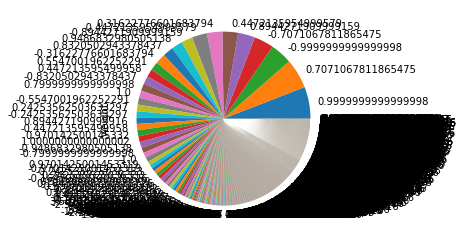

In [60]:
pearson_rdd=pearson_rdd.toDF()
pearson_df=pearson_rdd.toPandas()
pearson_df=pearson_df.rename(index=str, columns={"_3": "weight","_2": "user2", "_1":"user1"})
pearson_df["weight"].value_counts().plot.pie()
plt.gca().set_aspect("equal")

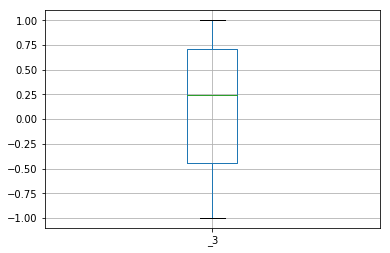

In [39]:
boxplot = pearson_df.boxplot(column=["_3"])

In [40]:
data = pearson_df[pearson_df._3 > 0 ]
G = nx.from_pandas_edgelist(data, "_1", "_2", ["_3"])

# Graph Pictorial Representation

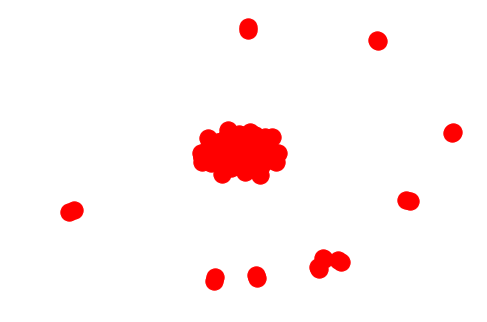

In [41]:
nx.draw(G)
plt.show()

In [42]:
nx.classes.function.density(G)

0.008411178941226337

In [44]:
Gc = max(nx.connected_component_subgraphs(G), key=len)

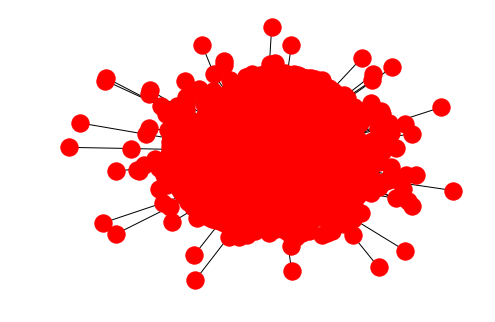

In [45]:
nx.draw(Gc)

# Applying GN Algorithm on the largest connected component

number of communities: 2
community : number_of_users
{0: 2312, 1: 3}


<BarContainer object of 2 artists>

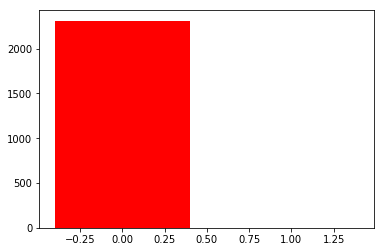

In [64]:
comp = nx.algorithms.community.centrality.girvan_newman(Gc)
cnt=0
gn_d={}
e={}

for c in next(comp):
    gn_d[cnt]=len(c)
    e[cnt] = c
    cnt+=1
print("number of communities: "+str(cnt)) 
print("community : number_of_users")
print(gn_d)
plt.bar(gn_d.keys(), gn_d.values(), color='r')  

# Drawback of GN

Drawbacks of graph partitioning and GN algorithm
● Computation effort required is immense
● Feasible even upto thousand nodes
● Infeasible for present day’s interactive
networks containing millions and billions
nodes

Overcoming
drawbacks

● Use of modularity
● Optimizing modularity

# Create a iGraph (Faster Computations) 
Performance
IGraph wins.

                            IGraph	NetworkX
Single-source shortest path	0.012 s	0.152 s
PageRank	                0.093 s	3.949 s
K-core	                    0.022 s	0.714 s
Minimum spanning tree	    0.044 s	2.045 s
Betweenness	       946.8 s (edge) + 353.9 s (vertex) (~ 21.6 mins)	32676.4 s (edge) 22650.4 s (vertex) (~15.4 hours)

In [57]:
import igraph as ig
g = ig.Graph()
# in order to add edges, we have to add all the vertices first
#iterate through edges and put all the vertices in a list
edges = Gc.edges()
vertex = []
for edge in edges:
    vertex.extend(edge)
g.add_vertices( list( set(vertex))) # add a list of unique vertices to the graph
g.add_edges(edges) # add the edges to the graph. 
"""
Note: add_edges is much quicker than add_edge. for every time add_edge is performed, the entire data structure in C has to be renewed with a new series ordering.
"""
print (g)

IGRAPH UN-- 2315 22910 --
+ attr: name (v)
+ edges (vertex names):
 3857 -- 1044, 2907, 4638, 750, 1258, 702, 73, 2933, 810, 1417, 613, 195,
1824, 1935, 3516, 765, 528, 596, 2127
 2585 -- 3141, 2152, 4522, 8237, 353, 1253, 4626, 202, 133, 6725, 5108, 122,
1777, 138, 143, 73, 444, 6691, 5762, 38, 4636, 1284, 2198, 2150, 8521, 183,
4544, 1724, 2923, 6651, 1782, 3628, 6698, 244, 417, 2191, 3619, 4162, 267,
6267, 458, 234, 230, 2632, 4726, 2974, 1260, 1426, 1385, 787, 3385, 4097,
5757, 1498, 5016, 1304, 4924, 783, 1241, 2240, 765, 6701, 592, 332, 748, 304,
184, 4575, 153
10436 -- 419
  577 -- 4159, 379, 765, 40
 7640 -- 353, 73, 4636, 184
 1373 -- 1487, 365, 8726, 967, 2289, 1724, 195, 571, 417, 196, 2983, 6102,
1426, 4559, 592, 776
 2969 -- 184
 3141 -- 2585, 249, 73, 4636, 3807, 4544, 7998, 2923, 1060, 4521, 234, 3133,
787, 1935, 592, 963, 184
 4395 -- 11232, 495, 689, 2141, 1717, 249, 73, 10909, 4925, 195, 3973, 1750,
891, 1385, 11218, 7392, 1607, 528, 321, 389, 3762, 626, 2671
 2734 --

# Applying FastGreedy

Bottom up hierarchical decomposition process. It will merge two current communities iteratively, with the goal to achieve the maximum modularity gain at local optimal
Pretty fast, can merge a sparse graph at linear time.
Resolution limit: when the network is large enough, small communities tend to be combined even if they are well-shaped.

{0: 542, 1: 717, 2: 701, 3: 5, 4: 157, 5: 149, 6: 5, 7: 12, 8: 2, 9: 2, 10: 2, 11: 3, 12: 4, 13: 3, 14: 2, 15: 2, 16: 2, 17: 3, 18: 2}


<BarContainer object of 19 artists>

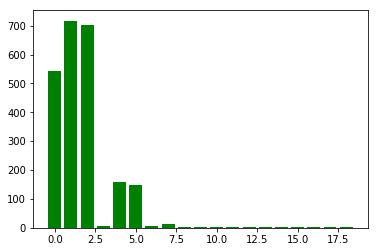

In [63]:
com_greedy = g.community_fastgreedy()
clusters = com.as_clustering()
# get the membership vector
membership = clusters.membership
d={}
for each in membership:
    if each in d:
        d[each]+=1
    else:
        d[each]=1
print (d)
plt.bar(d.keys(), d.values(), color='g')    
    

# Applying Eigenvectors
A top down approach that seeks to maximize modularity. It concerns decomposing a modularity matrix.
More accurate than fast greedy
Slower than fast greedy
Limitation: not stable on degenerated graphs (might not work!)


{0: 1358, 1: 375, 3: 297, 2: 285}


<BarContainer object of 4 artists>

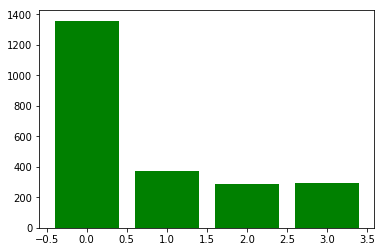

In [92]:
com_eig = g.community_leading_eigenvector()
eig_clusters= com_eig.as_cover()
eig_membership =eig_clusters.membership
vertices =g.vs()["name"]
eig_d={}
for each in eig_membership:
    if each[0] in eig_d:
        eig_d[each[0]]+=1
    else:
        eig_d[each[0]]=1
print (eig_d)
plt.bar(eig_d.keys(), eig_d.values(), color='g') 

In [113]:
eig_membership_np = np.array(eig_membership)
eig_membership_np=np.squeeze(eig_membership_np)
eig_membership_np = eig_membership_np.tolist()
vertices = [ invUsers[everyUser] for everyUser in vertices]

In [114]:
community_users_dict = {}
user_community_dict=dict(zip(vertices, eig_membership_np))
for k, v in user_community_dict.items():        
    community_users_dict[v] = community_users_dict.get(v, [])
    community_users_dict[v].append(k)
    
    

In [117]:
user_community_df = pd.DataFrame.from_dict({"user_id" : list(user_community_dict.keys()) , "community" :  list(user_community_dict.values())})

In [128]:
# first_comm=next(comp)
community_count = { community:len(community_users_dict[community]) for community in community_users_dict }

In [129]:
import operator
max_count_community = max(community_count.items(), key=operator.itemgetter(1))[0]
max_count_community

0

In [130]:
first_comm_list=community_users_dict[max_count_community]


['NqfujE5R7iKO7V9XKS1lEA',
 'rLdk5WEUcMdhmyzwshiwrg',
 'G1As2p25tMVgcPGsYNzEtw',
 'Rf_7Q0BV96n80ntefUtLBQ',
 'XiE1PaIQrdVifobwSqpGNQ',
 'jWNgiozC1E_jqmubrrEGgg',
 'naoPWjE5hPjk00w8uIQp8A',
 'yCV3QFoRx3YzWnYcpikVFQ',
 'x7Ejxxz6LLm9muyU9e6l9A',
 'BDkI8-rEQ5WTSkCBRdZhgQ',
 '2sF49Ozjc_klEuYk9zr6RA',
 'gJPyzy6oZz5WJheIOs-Sdw',
 '3cAIe7j3fqrlfodQ_SDT7g',
 'JxDhpIhS7qUJbXbe2yRvAw',
 'PjFiilDarRDL4caHXuC3NQ',
 '-EdQTVyh9dgjp0N-gFWWDA',
 'AbFEUQjISZGr9f8yr7HNfA',
 'i192ci0Stiju5kjKJys6KQ',
 'xciAnQcGAyGZC2rwisj4fQ',
 'D76mLV3vo_xqPkE8FXfMtw',
 'nhpNFlbYgDZb1NitKGuqbQ',
 'hZEV1dgTHdIDMiLOFqt61A',
 'K5WR9GBgGHSeplxNAkU8Xg',
 'A5lUFfsCCHxh6j3hbKobzA',
 'nZuH05cjCs7o1fY3OM1yNw',
 'XqMcGxIBkTC43l08HUq3hw',
 'k5WmQ0SXLGezTU58ICj_cA',
 'H52DM1C3nFYXh0-zAWrRNw',
 'O-TRfZAc3fz9IyLDcewUuQ',
 'C3LMc2EDAgD_gZoRXTIGpw',
 'QmJr-G3MDLuo0i-f0AZX4w',
 'NegHL-xwylWqMFGqvtwYug',
 '7LSpKO5_dhPIHemmploFMw',
 'l8R1_8CWvOvsAClYgQ6DXg',
 'D-2Z30GiK2PIQOVM0pSyQg',
 '3PWGQQNEQLKQBSuMWHJ0Vg',
 'wMDka0MxHa3XjMZ1egqBTQ',
 

# Get user features and friends list

In [193]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.sql.functions import col, split
import pyspark.sql.functions as funcs
grouped_users = city_df_sql.groupby("user_id").agg({'*':'count'})
size_ = udf(lambda xs: len(xs), IntegerType())
city_df_sql = city_df_sql.withColumn("text_count", size_(col("text")))
users_more_details = grouped_users.join(users_df, ['user_id'])
# users_who_have_friends = users_more_details.filter(users_more_details.friends!='None')
users_more_details=users_more_details.withColumnRenamed("count(1)","business_reviewed_count")
users_all_Details_bR = users_more_details.join(city_df_sql, ['user_id'])
users_details_all_bus_open_Review =users_all_Details_bR.filter(users_all_Details_bR.is_open==1)
users_details_all_bus_open_Review = users_details_all_bus_open_Review.withColumn("yelping_since_years", (2018-split(col('yelping_since'),"-")[0]))
users_details_all_bus_open_Review = users_details_all_bus_open_Review.withColumn("friends_count",funcs.size(split(col("friends"), ",\s*"))).withColumn("elite_count", funcs.when(col("elite") == 'None',0).otherwise(funcs.size(split(col("elite"), ",\s*"))))
users_details_all_bus_open_Review=users_details_all_bus_open_Review.drop('city').drop('reviews_cool').drop('reviews_funny').drop('business_name').drop('postal_code').drop('name').drop('elite').drop('yelping_since').drop('attributes').drop('address').drop('hours').drop('is_open').drop('neighborhood').drop('state').drop('friends').drop('text')
user_features =users_details_all_bus_open_Review.toPandas()



In [194]:
users_details_all_bus_open_Review =users_all_Details_bR.filter(users_all_Details_bR.is_open==1)
user_friends_df= users_details_all_bus_open_Review.select('user_id','friends').toPandas()
user_friends_df = user_friends_df.groupby(['user_id','friends']).size().reset_index().rename(columns={0:'count'}).drop(columns=['count'])
# user_df=user_data[['user_id', 'friends']]

# Pick a test User

In [192]:
test_user= first_comm_list[3]

In [195]:
# user_features = pd.read_csv("/Users/monisha/Desktop/USC/ThirdSemester/CSCI541-DataMining/Project/user_business_rating_49k_features_added.csv")

user_features =user_features.groupby(['user_id','business_reviewed_count', 'average_stars', 'compliment_cool' ,'compliment_cute' , 'compliment_funny', 'compliment_hot', 'compliment_list','compliment_more','funny','compliment_note','fans','friends_count','elite_count','cool','compliment_photos','compliment_writer','compliment_profile','compliment_plain', 'review_count','useful','yelping_since_years']).size().reset_index().rename(columns={0:'count'})
user_features=user_features.drop(columns=['count'])

In [196]:
user_community_df_full= user_community_df.merge(user_features, left_on="user_id" ,right_on="user_id",how="inner")

In [197]:
user_community_df_full

,user_id,community,business_reviewed_count,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,...,friends_count,elite_count,cool,compliment_photos,compliment_writer,compliment_profile,compliment_plain,review_count,useful,yelping_since_years
0,NqfujE5R7iKO7V9XKS1lEA,0,5,3.90,0,0,0,0,0,0,...,1,0,0,0,0,0,0,9,7,5.0
1,Ijql5IV_RTOZphYKvoInrA,1,11,3.74,0,0,0,0,0,0,...,1,0,0,0,0,0,2,44,6,4.0
2,3xM08itCG-mxcZ1CG2lPlg,1,3,4.12,0,0,0,0,0,0,...,121,0,2,0,0,0,0,25,4,3.0
3,rLdk5WEUcMdhmyzwshiwrg,0,6,4.67,0,0,0,0,0,0,...,1,0,0,0,0,1,1,8,33,6.0
4,G1As2p25tMVgcPGsYNzEtw,0,4,3.18,0,0,0,0,0,0,...,52,0,2,0,0,0,0,9,5,2.0
5,Rf_7Q0BV96n80ntefUtLBQ,0,5,3.75,0,0,0,0,0,0,...,1,0,0,0,0,0,0,8,3,2.0
6,XiE1PaIQrdVifobwSqpGNQ,0,3,3.26,0,0,0,0,0,0,...,108,0,0,0,0,0,0,17,1,3.0
7,jWNgiozC1E_jqmubrrEGgg,0,6,3.00,0,0,0,0,0,0,...,1,0,0,0,0,0,0,14,0,1.0
8,naoPWjE5hPjk00w8uIQp8A,0,7,4.49,3,2,3,5,0,0,...,89,0,5,1,3,0,1,37,32,4.0
9,TgcF4ANIl0wm-m3FSJbOMw,3,14,3.80,0,0,0,0,0,0,...,1,0,1,0,0,0,0,15,0,4.0


# Assign Community as Label and Pick Top Features

In [198]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [199]:
scaler.fit(user_community_df_full.values[:,2:])
user_community_transformed= scaler.transform(user_community_df_full.values[:,2:])

/Users/vijethapv/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [200]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
array = user_community_transformed
array2 = user_community_df_full
X = array[:,0:]
Y = array[:,0]
Y = Y.astype('int')
model = LogisticRegression()

rfe = RFE(model, 10)
rfe = rfe.fit(X, Y)
# summarize the selection of the attributes
print("Num Features: ", rfe.n_features_)
print("Selected Features: ",rfe.support_)
print("Feature Ranking:",  rfe.ranking_)
names = user_community_df_full.columns.values
a=np.array(names)

selectedFeatures = ['user_id']

f = rfe.support_.tolist()
for i in range(0,len(names[2:])):
    if f[i]==True:
        selectedFeatures.append(names[i+2])
print (selectedFeatures )
        

Num Features:  10
Selected Features:  [ True False False  True False False False False False  True  True  True
  True  True False False  True  True  True False False]
Feature Ranking: [ 1 12  9  1  7  4  8  6  3  1  1  1  1  1 10  5  1  1  1 11  2]
['user_id', 'business_reviewed_count', 'compliment_cute', 'compliment_note', 'fans', 'friends_count', 'elite_count', 'cool', 'compliment_profile', 'compliment_plain', 'review_count']


In [201]:
test_user_features = user_features[user_features.user_id ==test_user]

In [202]:
community_features = user_features[ user_features['user_id'].isin(first_comm_list)]

In [203]:
community_features_i =community_features.reset_index(drop=True)
community_features_i_new = community_features_i[selectedFeatures]

# Scale features and compute cosine similarity

In [204]:
comm_feat_X =community_features_i_new.values[:,1:]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(comm_feat_X[:,1:])
comm_feat_X= scaler.transform(comm_feat_X[:,1:])

/Users/vijethapv/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [217]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(community_features_i_new.values[:,1:], community_features_i_new.values[:,1:])

In [206]:
cos_sim = cosine_similarity(comm_feat_X, comm_feat_X)

In [207]:
friends_list_test_user =user_friends_df[user_friends_df['user_id']==test_user]['friends'].values[0]
if friends_list_test_user=='None':
    friends_list_test_user=[]
else:
    friends_list_test_user = friends_list_test_user.split(',')

In [208]:
index_test_user= community_features_i_new[community_features_i_new.user_id==test_user].index.values[0]

In [209]:
community_features_i_new = community_features_i_new[~community_features_i_new.user_id.isin(friends_list_test_user)]

In [210]:
cos_values = np.array(cos_sim[index_test_user])

In [211]:
sorted(cos_values)
cos_values[index_test_user] = 100

# Select Top 10 Users And Recommend Them As Friends If Not Already Friends

In [212]:
index =np.argsort(cos_values)[::-1][1:11]
filter_ind = []

In [213]:
suggest_users = community_features_i_new.ix[index]
suggest_users

/Users/vijethapv/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,user_id,business_reviewed_count,compliment_cute,compliment_note,fans,friends_count,elite_count,cool,compliment_profile,compliment_plain,review_count
629,R3xYyCXSnSo_J278bPQ1GA,5,0,1,0,1,0,0,0,0,8
1357,zv3uF3mhC2JROTWF_994Xw,3,0,1,0,1,0,0,0,0,7
196,7wce5smnALiGPlEUom2hvA,4,0,1,0,1,0,0,0,0,7
1332,yvpTmbvbCnUZ1nUq4QGuqQ,2,0,1,0,1,0,0,0,0,7
1212,sK2Zqs45YXFYk6F81cKAdQ,4,0,1,0,1,0,0,0,0,7
137,4pgTP10Zm7_7mP7PjpDEiw,2,0,1,0,1,0,0,0,0,7
172,6Kb1h2mBmXQhb5bHU4Fnog,7,0,1,0,1,0,0,0,0,9
1313,xvZCvHApnJm2byv8gKyd-w,6,0,1,0,1,0,1,0,0,7
883,dTDP9MKgBETZDDapTyCv6A,2,0,1,0,2,0,0,0,0,8
266,BBoGIIRD0NUB-CU0wWHBFQ,7,0,1,0,1,0,3,0,0,9


In [214]:
given_user = community_features_i_new.ix[[index_test_user]]
given_user

/Users/vijethapv/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,user_id,business_reviewed_count,compliment_cute,compliment_note,fans,friends_count,elite_count,cool,compliment_profile,compliment_plain,review_count
642,Rf_7Q0BV96n80ntefUtLBQ,5,0,1,0,1,0,0,0,0,8


# Cold start

Find elite users in each community for default recommendation

In [216]:
import operator
max_elite = user_community_df_full.groupby('community')['elite_count'].max()
sorted_max_elite = sorted(max_elite.items(), key=operator.itemgetter(1), reverse=True)
list_suggested_users = []
for item in sorted_max_elite[:11]:
    list_suggested_users.append(user_community_df_full[(user_community_df_full['community'] == item[0]) & 
                                              (user_community_df_full['elite_count'] == item[1])]['user_id'].values[0])
final_cold_start_suggestion =  user_community_df_full[user_community_df_full['user_id'].isin(list_suggested_users)]

final_cold_start_suggestion = final_cold_start_suggestion.sort_values(by=['elite_count'],ascending=False)
final_cold_start_suggestion

,user_id,community,business_reviewed_count,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,...,friends_count,elite_count,cool,compliment_photos,compliment_writer,compliment_profile,compliment_plain,review_count,useful,yelping_since_years
1598,p_azadim_uWFOXAhhKB3ag,2,18,3.56,504,15,504,519,7,35,...,1314,11,1125,106,218,4,354,739,1199,11.0
1219,TYCkjEHPSJSnFb6m6GDluw,0,3,2.78,219,2,219,110,3,7,...,520,10,1549,18,49,5,473,331,1159,10.0
2122,xCdBM9yKyKyqW9qC2RqAkQ,3,8,4.22,6818,457,6818,5785,255,972,...,2294,9,22626,11118,3899,1106,7080,765,22580,9.0
2308,EL2Ix01VF_whB5g9CHh2Ag,1,3,3.87,24,0,24,15,0,5,...,234,8,91,4,6,1,34,178,164,10.0


Suggesting friends to users who are not part of any community initially

In [218]:
user_vs_business ={}
import pandas as pd
for k , v in usersOnlyUserCF.items():
    user_vs_business [k] =  len(v)
data = {"user" : list(user_vs_business.keys()) , "count_business" : list(user_vs_business.values())}
df=pd.DataFrame.from_dict(data)
user_ids =df.user.unique()
user_ids_str = [ invUsers[user] for user in user_ids]
len(user_ids_str)
community_users1 = [i for i in user_community_dict.keys()]
len(community_users1)
users_not_in_community = set(user_ids_str).difference(set(community_users1))
len(users_not_in_community)
cold_start_test_user = list(users_not_in_community)[0]
cold_start_suggested_friend_list = final_cold_start_suggestion
final_cold_start_suggestion

,user_id,community,business_reviewed_count,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,...,friends_count,elite_count,cool,compliment_photos,compliment_writer,compliment_profile,compliment_plain,review_count,useful,yelping_since_years
1598,p_azadim_uWFOXAhhKB3ag,2,18,3.56,504,15,504,519,7,35,...,1314,11,1125,106,218,4,354,739,1199,11.0
1219,TYCkjEHPSJSnFb6m6GDluw,0,3,2.78,219,2,219,110,3,7,...,520,10,1549,18,49,5,473,331,1159,10.0
2122,xCdBM9yKyKyqW9qC2RqAkQ,3,8,4.22,6818,457,6818,5785,255,972,...,2294,9,22626,11118,3899,1106,7080,765,22580,9.0
2308,EL2Ix01VF_whB5g9CHh2Ag,1,3,3.87,24,0,24,15,0,5,...,234,8,91,4,6,1,34,178,164,10.0
